### Dependencias

In [1]:
# Librerias para el tratamiento de los datos
import pandas as pd
import numpy as np
import math

# Librerias para la graficación de los datost
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
import plotly.express as px

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Permite ignorar los warnings de la libreta al generar algunos modelos
import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Libreria necesaria para los gráficos interactivos
from ipywidgets import interact 
import plotly.express as px

# Librerias necesarias para el aprendizaje de modelos
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split

#Libreria para reducción de dimensionalidad
from sklearn.decomposition import PCA

#Modelos
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#Serializacion de modelos
import pickle

#Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

#Medicion de tiempos
import time

#Semilla para reproducción de resultados
SEED = 1234

### Carga de datos

In [2]:
df = pd.read_csv('./data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


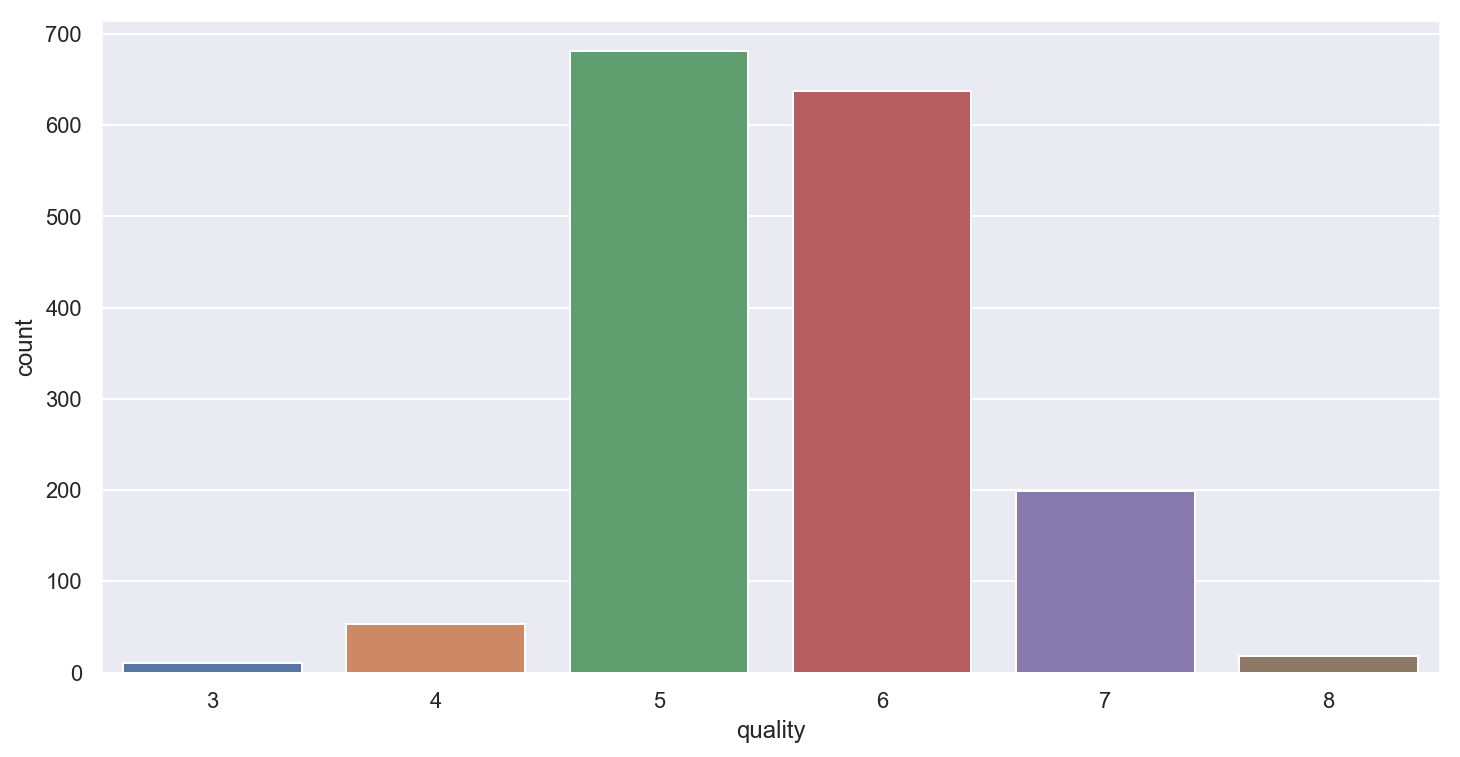

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(df['quality'])
plt.show()

Vamos a converir el problema a un problema de clasificación, por lo que debemos dividir la clase quality en grupos,
 en concreto van a ser **buen vino** y **mal vino**, estableciendo ese umbral en **6.5**.

In [6]:
df['quality'] = df['quality'].apply(lambda x: 1 if x > 6.5 else 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


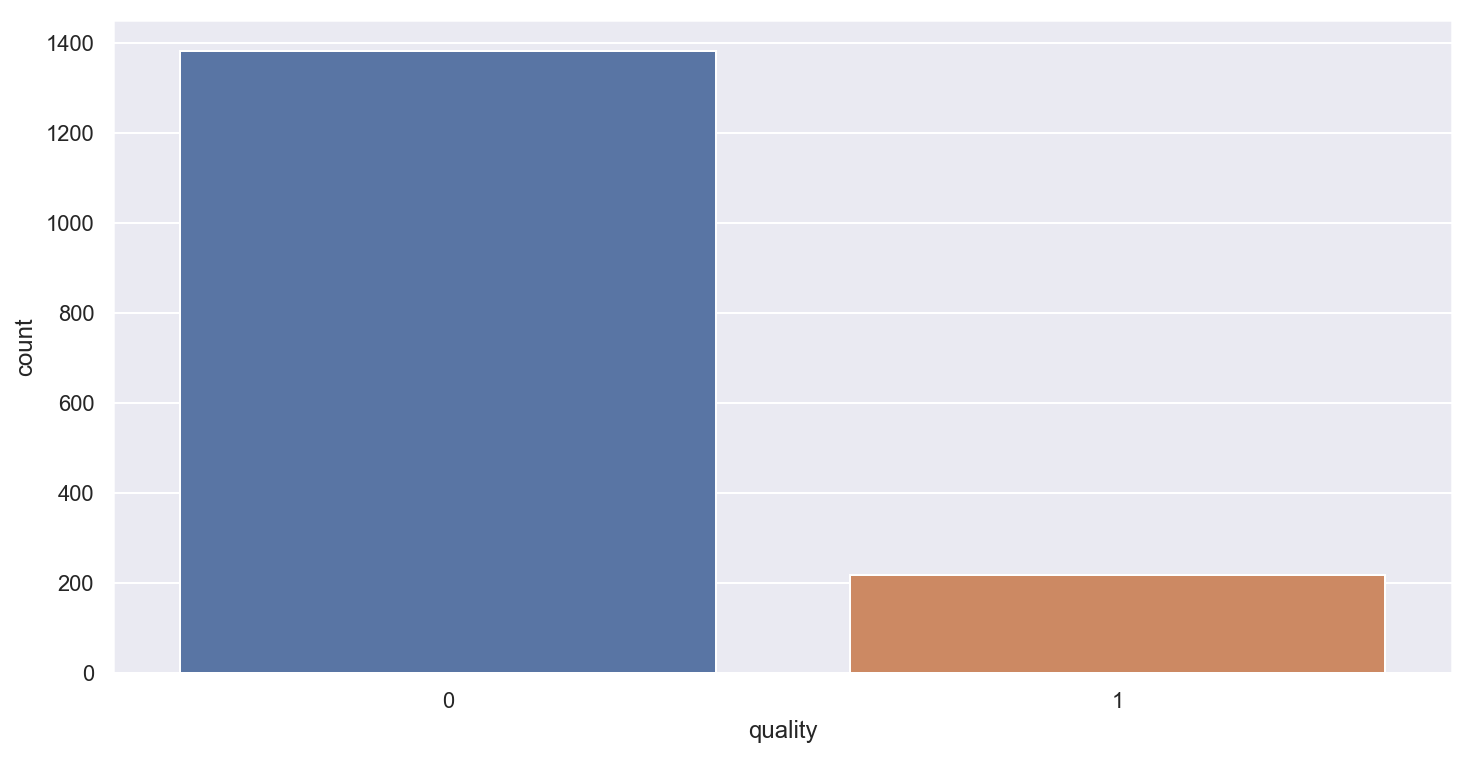

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(df['quality'])
plt.show()

In [8]:
bad_percentage = len(df[df['quality']==0])/len(df)
good_percentage = 1-bad_percentage


print(f"Hay un {np.round(bad_percentage, 3)}% con respecto a la clase 0")
print(f"Hay un {np.round(good_percentage,3)}% con respecto a la clase 1")

Hay un 0.864% con respecto a la clase 0
Hay un 0.136% con respecto a la clase 1


Observamos que hay muy pocos ejemplos con respecto a la clase good, por lo tanto, habrá que hacer alguna tecnica de oversampling o undersampling para equilibrar los registros

Subdividimos el conjunto de datos, para que con uno de ellos entrenemos nuestros modelos y con el último obtengamos una validación del mejor modelo obtenido durante el proceso de entrenamiento y análisis de los datos

In [9]:
X = df.drop(columns=['quality']).copy()
y = df['quality'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y, shuffle=True, random_state=SEED)

df_modelar = X_train
df_modelar['quality'] = y_train
df_modelar_new = X_val
df_modelar_new['quality'] = y_val

print("Tamaño del conjunto de datos disponibles: ", len(df_modelar))
print("Tamaño del conjunto de nuevos datos: ", len(df_modelar_new))

Tamaño del conjunto de datos disponibles:  1359
Tamaño del conjunto de nuevos datos:  240


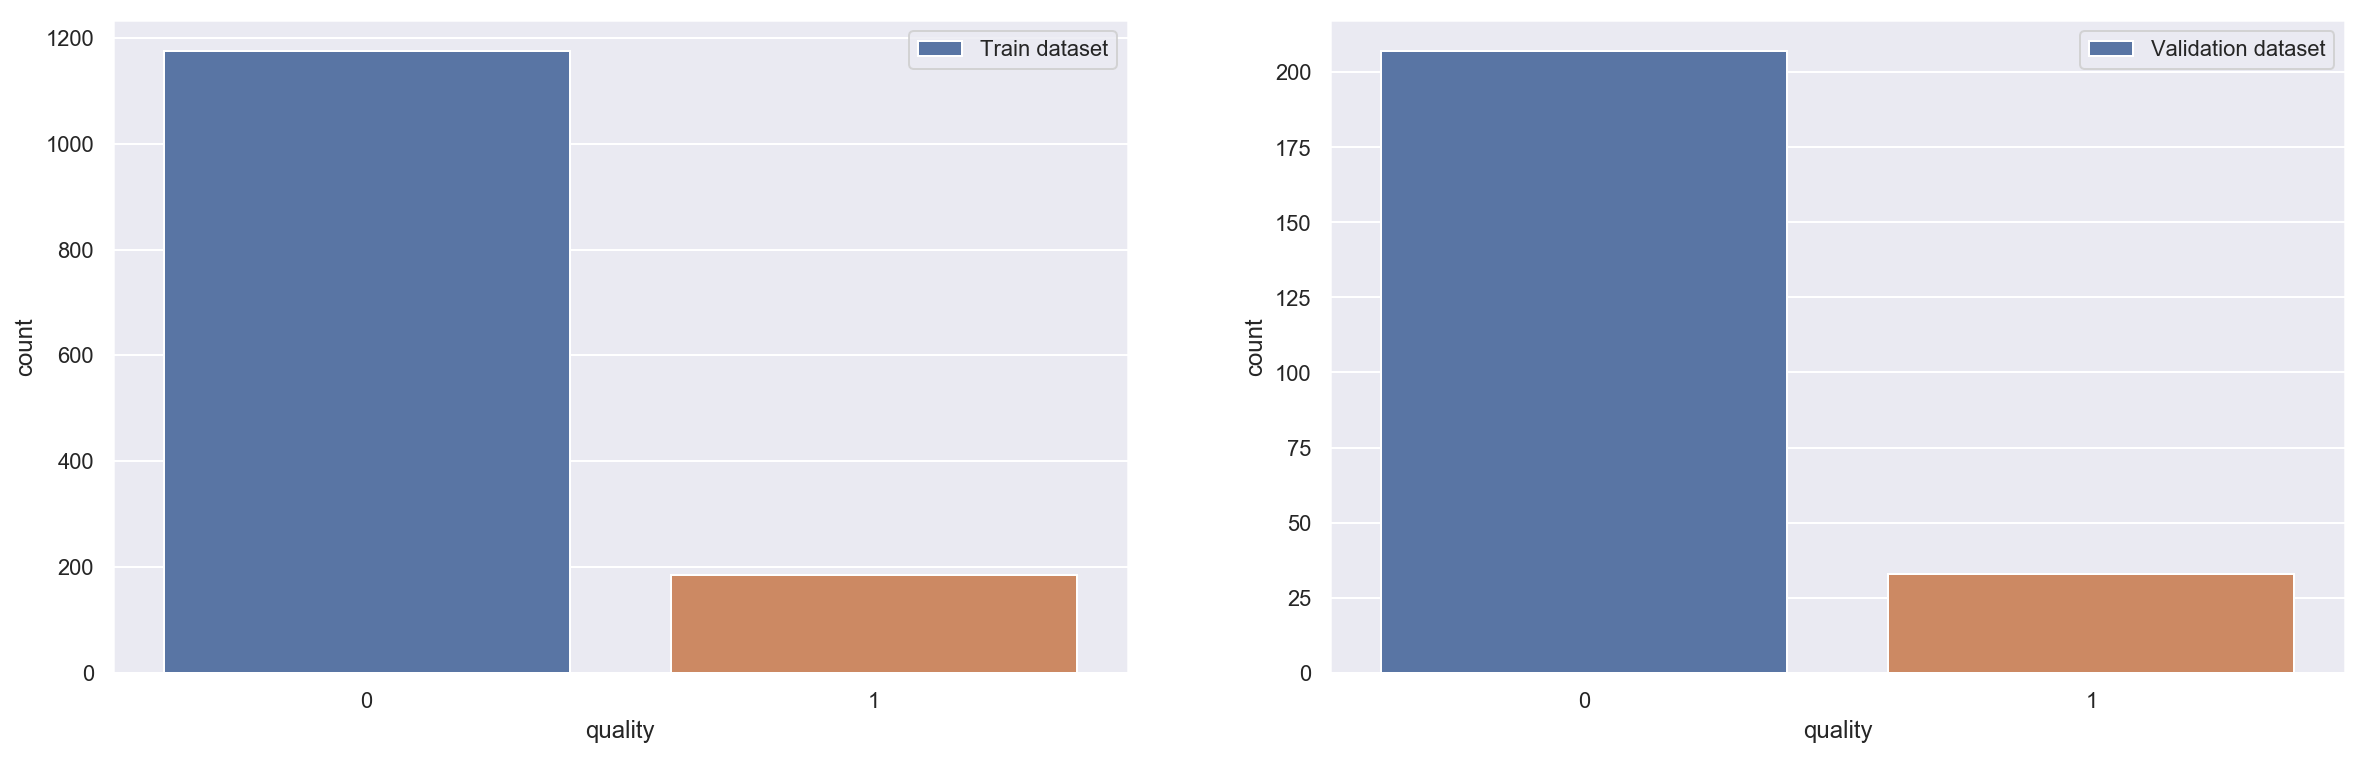

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
sns.countplot(df_modelar['quality'], label='Train dataset', ax=ax1)
sns.countplot(df_modelar_new['quality'], label='Validation dataset', ax=ax2)
ax1.legend()
ax2.legend()
plt.show()

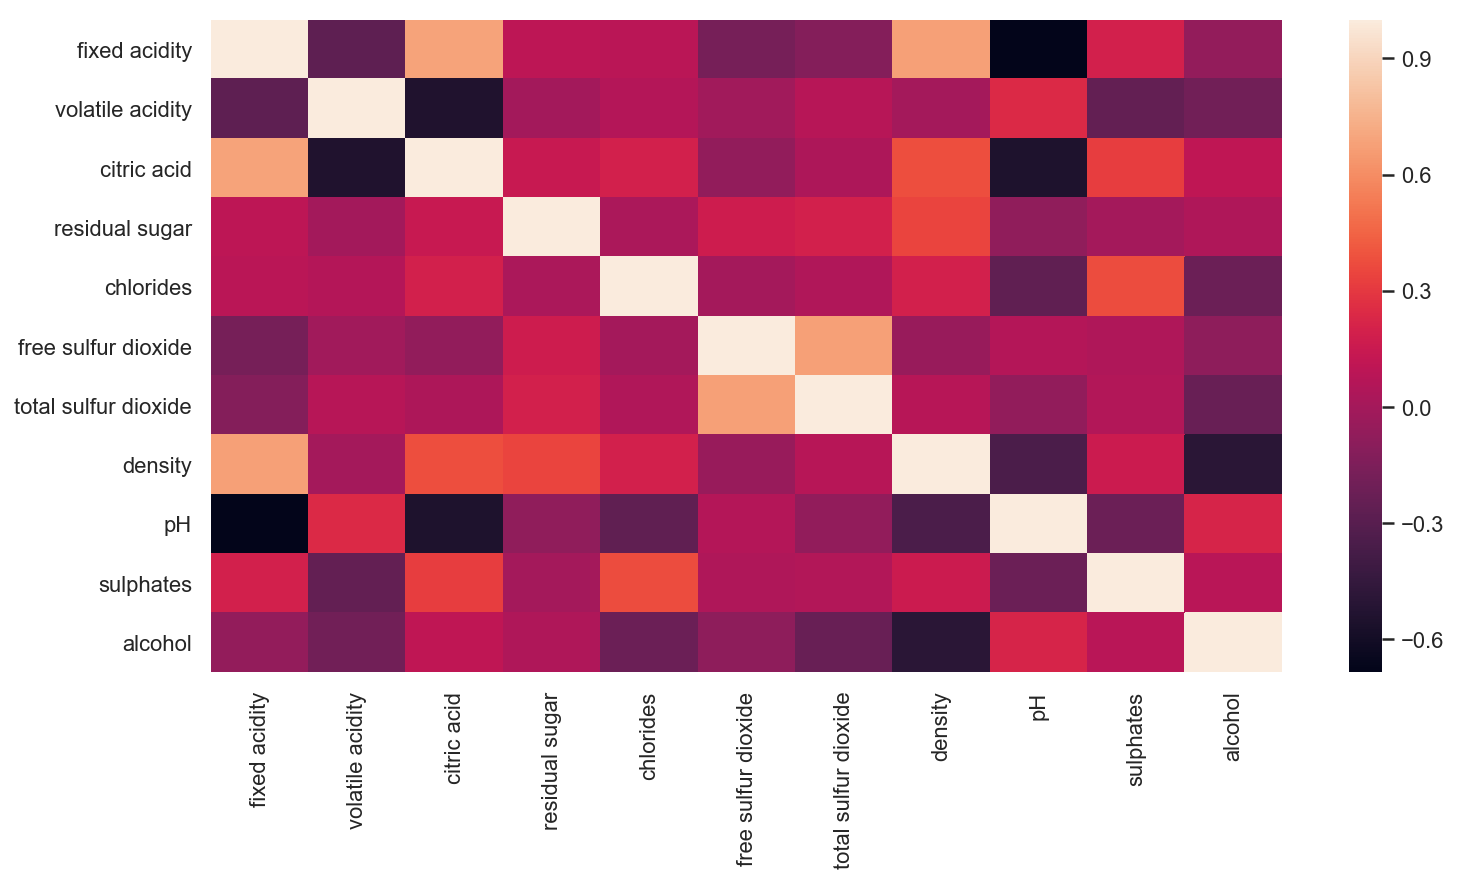

In [11]:
# Correlación perteneciente a las variables menos la variable objetivo
plt.figure(figsize=(12,6))
sns.heatmap(df_modelar[df_modelar.columns[:-1]].corr())
plt.show()

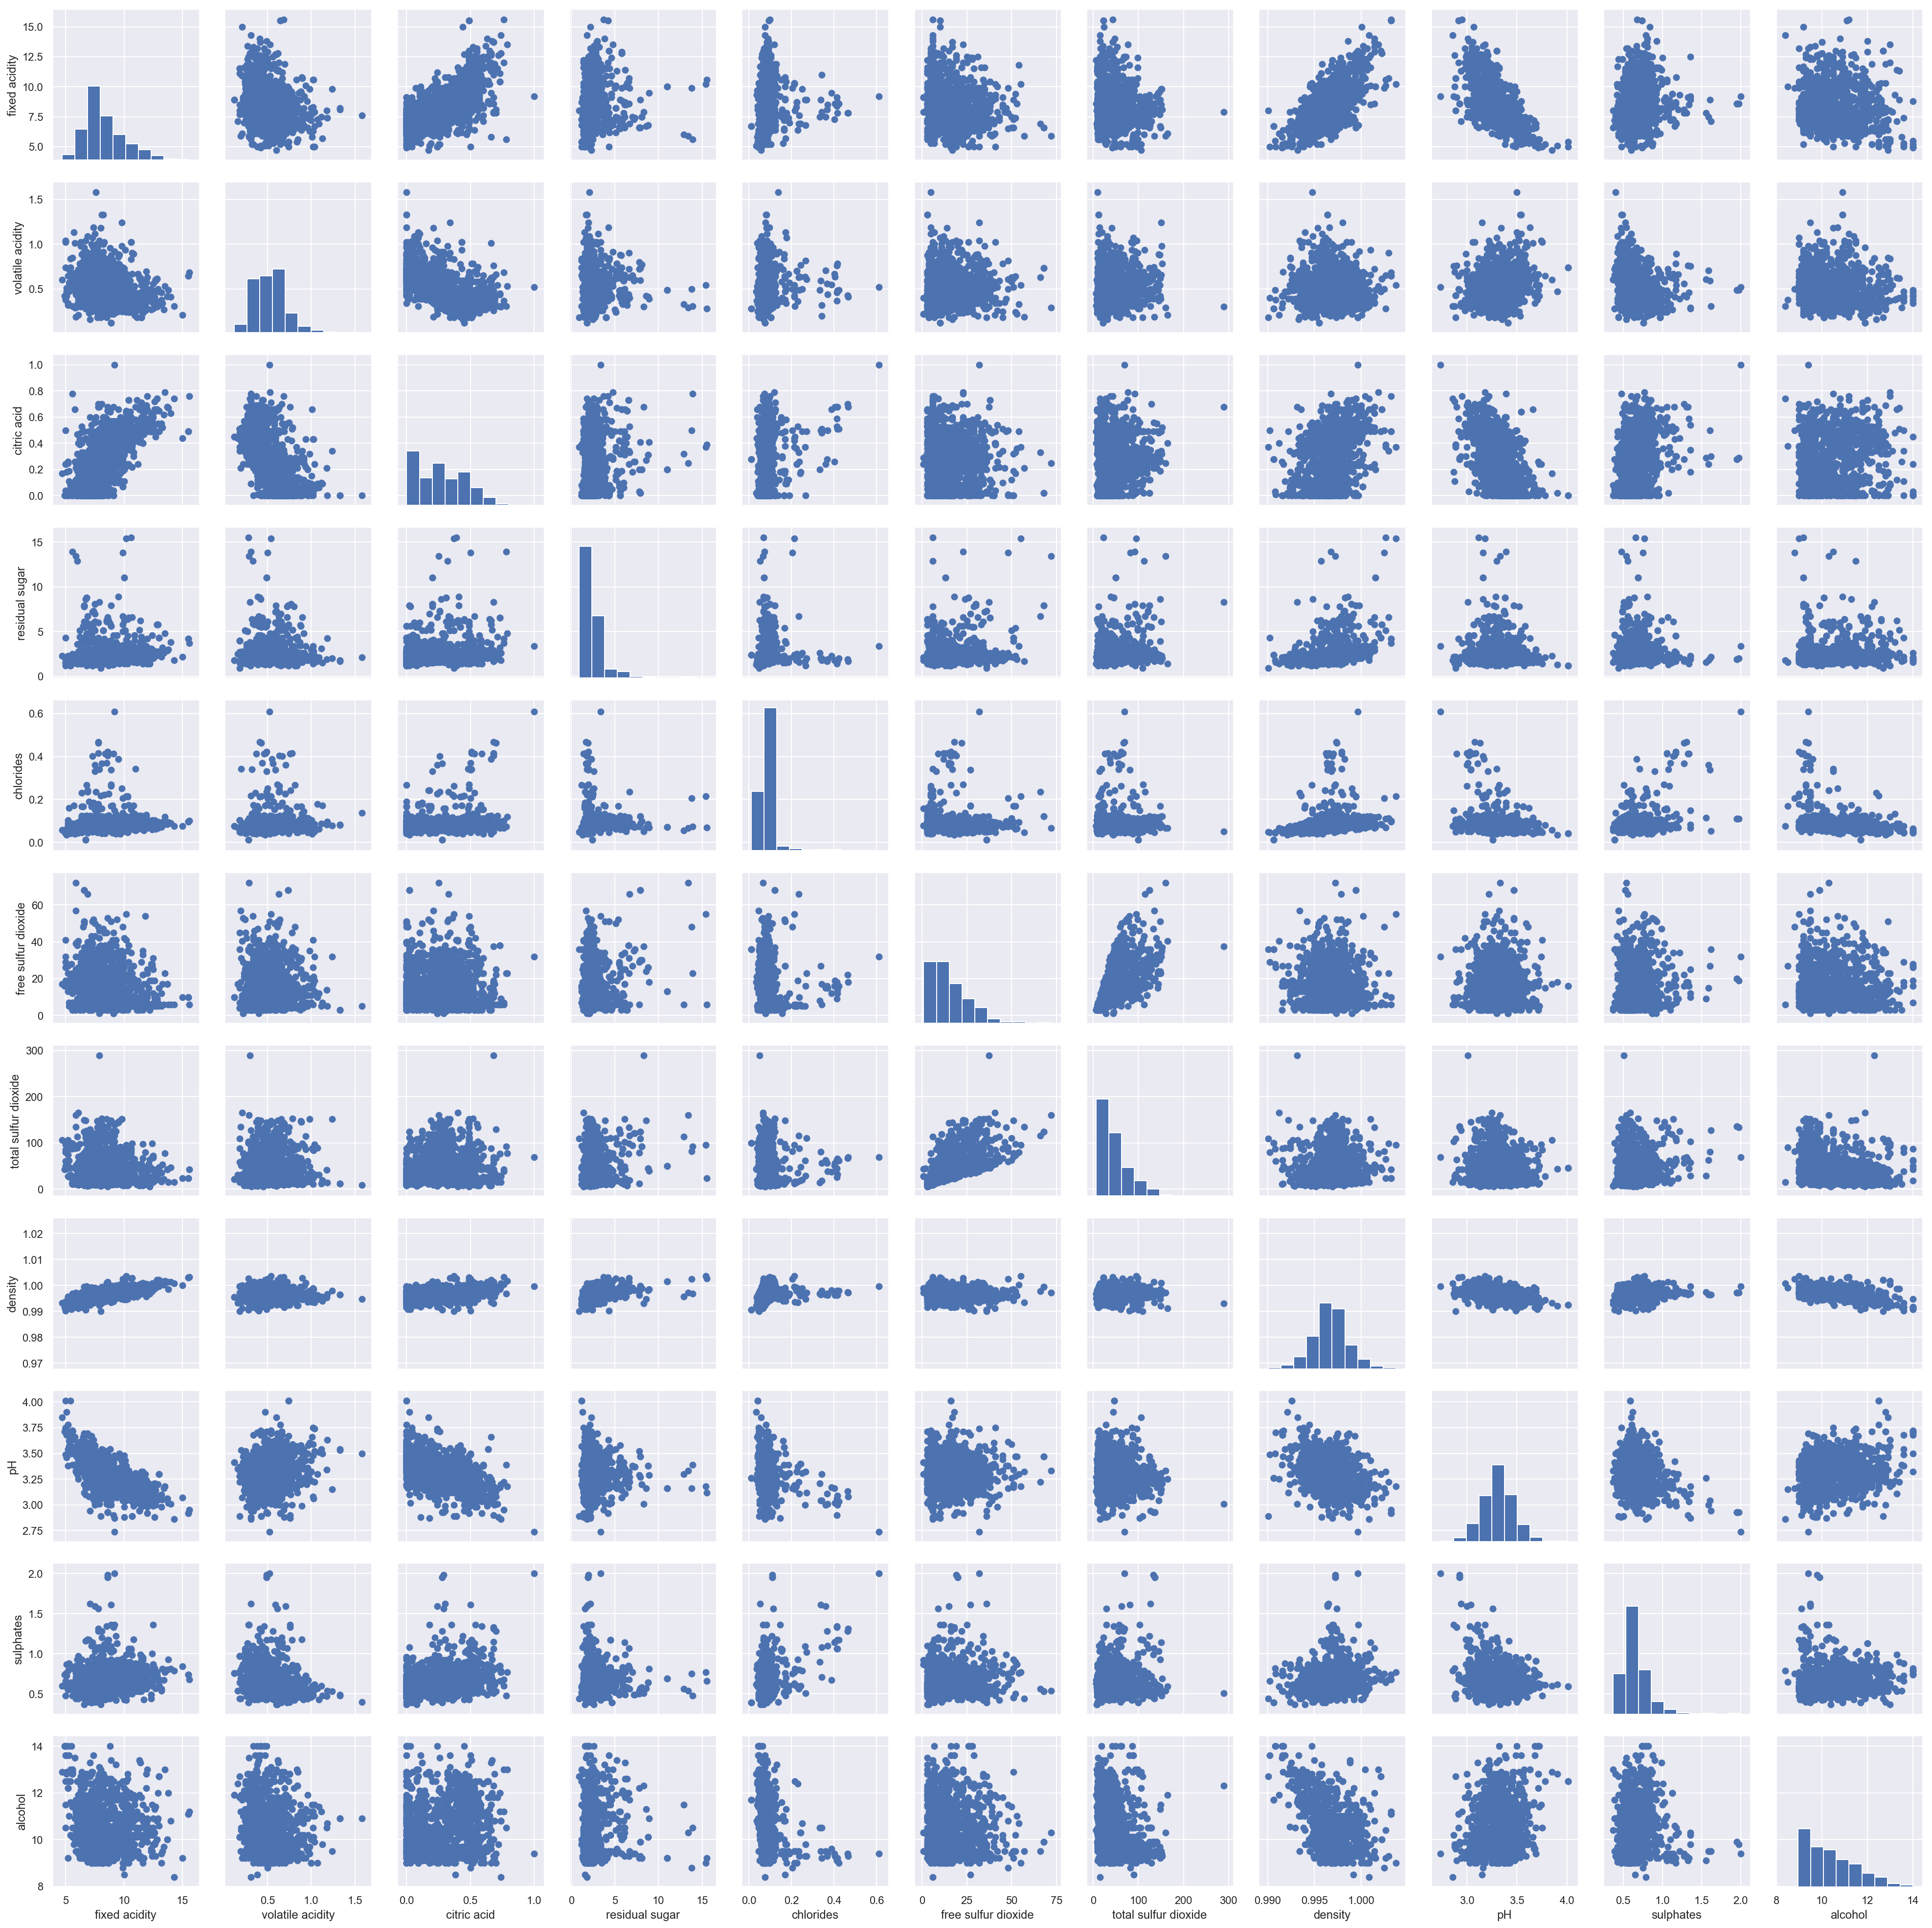

In [12]:
g = sns.PairGrid(df_modelar[df_modelar.columns[:-1]])
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

Analisis de la relacion entre la densidad y el fixed acidity

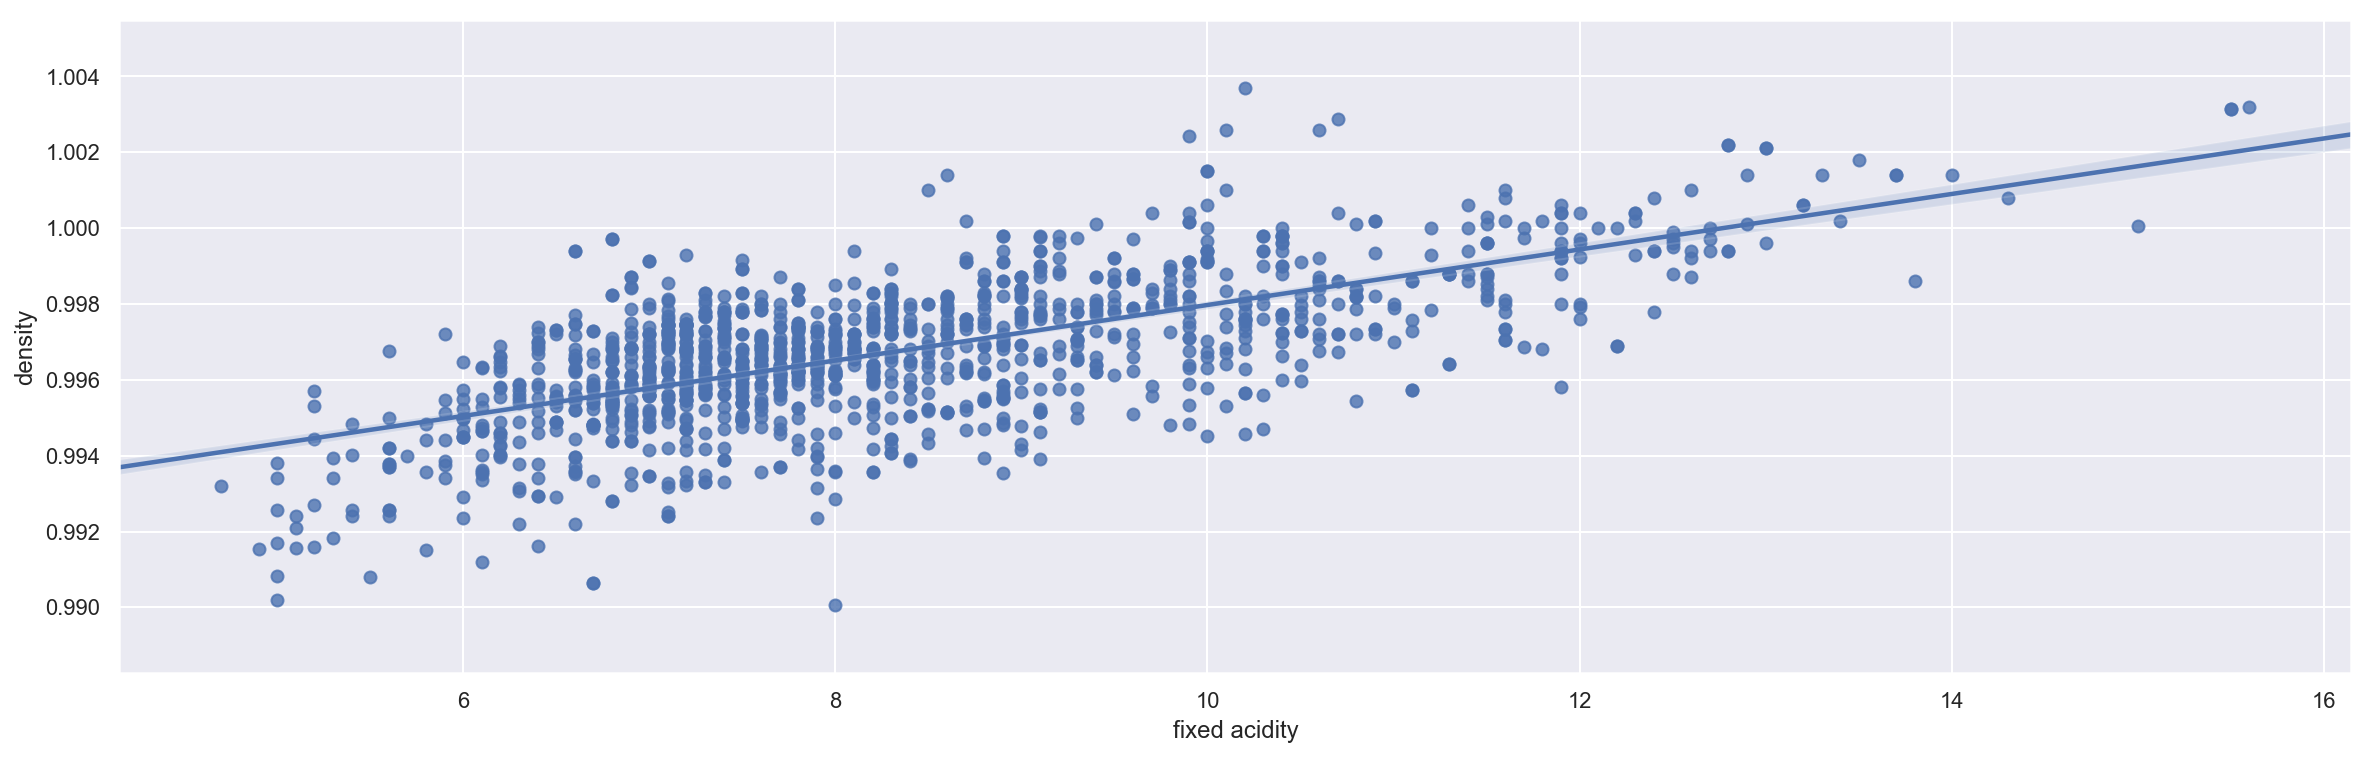

In [13]:
plt.figure(figsize=(20,6))
sns.regplot(x='fixed acidity', y='density', data=df_modelar)
plt.show()

Podemos observar que a mayor nivel de fixed acidity, obtenemos mayor densidad en el vino

Analisis entre la densidad y el alcohol

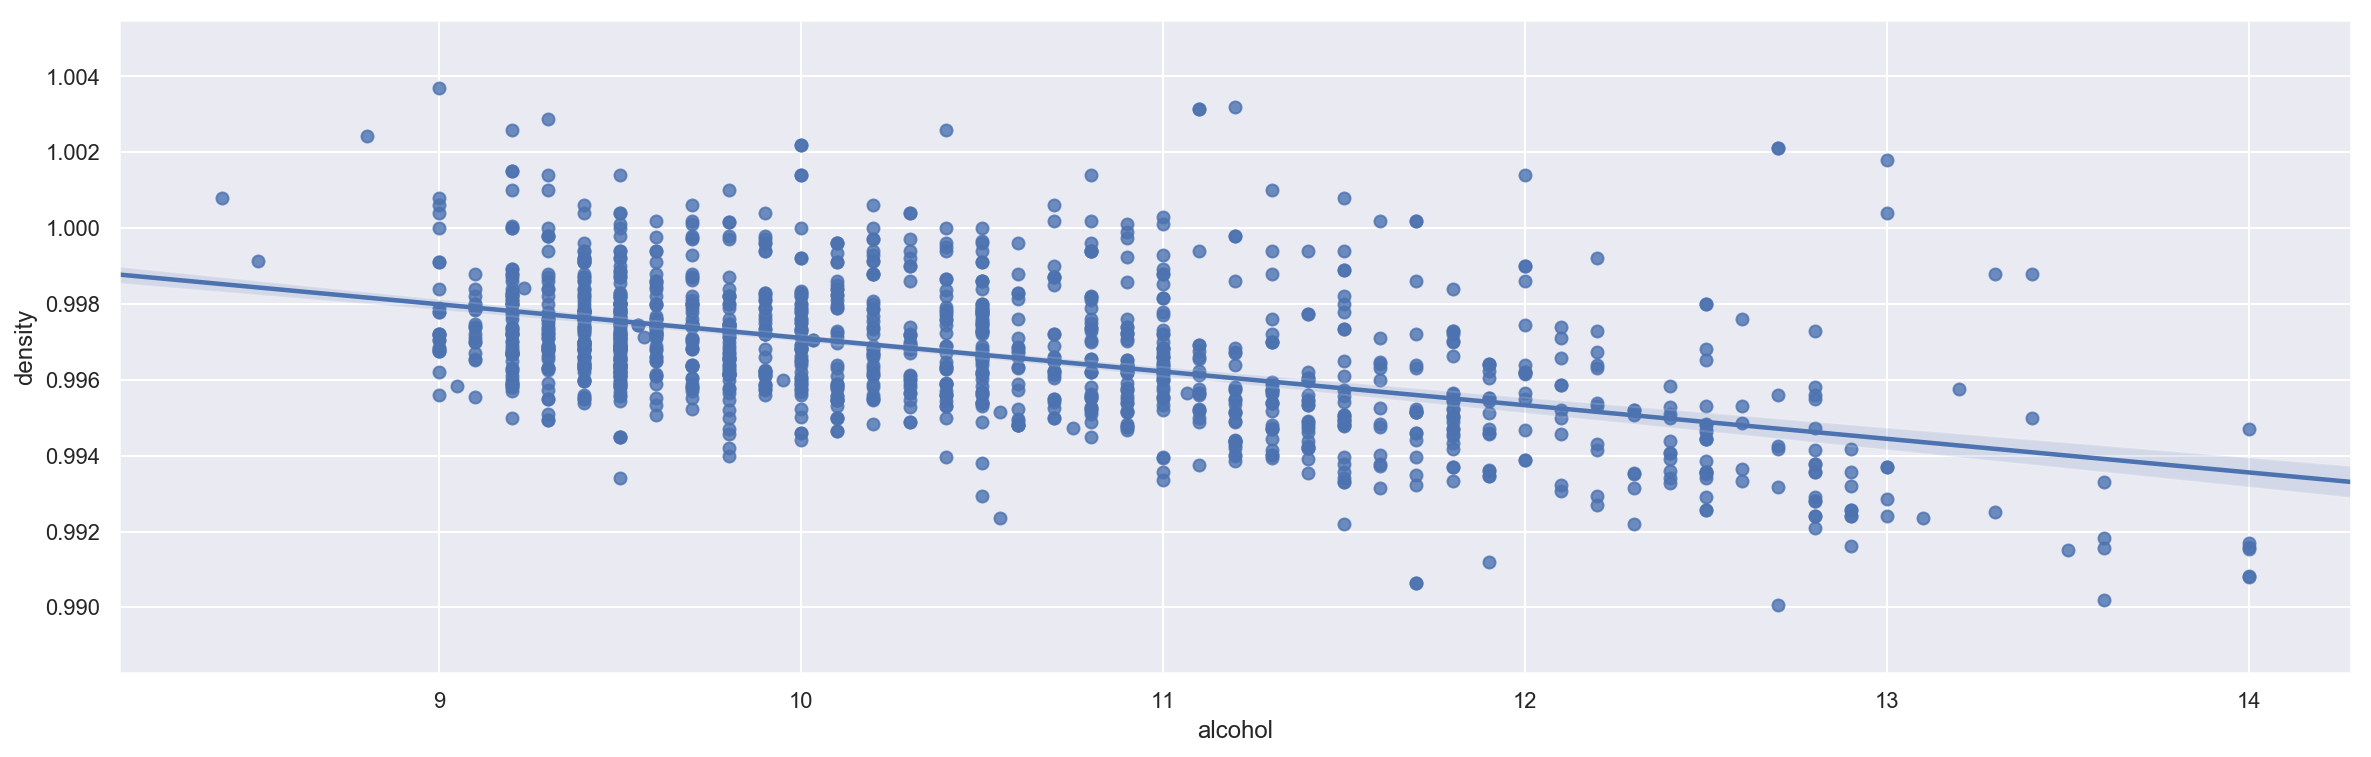

In [14]:
plt.figure(figsize=(20,6))
sns.regplot(x='alcohol', y='density', data=df_modelar)
plt.show()

Podemos concluir que a mayor nivel de alcohol en el vino, menor densidad presenta

Ahora vamos a hacer un primer modelo para observar que tal se comportan los datos

In [15]:
X = df_modelar.drop(columns='quality').copy()
y = df_modelar['quality'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=SEED, max_depth=2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f'Accuracy del train: {clf.score(X_train, y_train)}')
print(classification_report(y_test, y_pred))

Accuracy del train: 0.8776448942042319
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       235
           1       1.00      0.03      0.05        37

    accuracy                           0.87       272
   macro avg       0.93      0.51      0.49       272
weighted avg       0.89      0.87      0.81       272



Observamos que el accuracy es alto, pero después si observamos el f1 score de cada uno de los valores, podemos ver que para los registros cuyo valor es 1, nuestro modelo no es capaz de clasificarlos correctamente, y esto es debido a lo que hemos comentado previamente sobre el desequilibrio de los datos. Siendo la clase mayoritaria la clase **0**.

In [17]:
df_columns = df_modelar.select_dtypes(include=np.number).columns.tolist()
df_columns.remove('quality') #Eliminamos la variable clase

In [18]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                             ('scaler', StandardScaler())])

#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_modelar_trans = ColumnTransformer(transformers=[('num', num_transformer, df_columns)])

In [19]:
#Generamos el objeto SMOTE para la clase minoritaria para así balancear el conjunto de datos
sm = SMOTE(random_state=SEED, sampling_strategy='not majority')

In [20]:
models = [
    'SGD',
    'Logistic regression',
    'Decision tree',
    'Random forest',
    'Xgboost'
]

params = { 
        'SGD': 
            {'clf': SGDClassifier(random_state=SEED),
            'params': [{'clas__max_iter': [50, 100, 1000], 'clas__tol': [1e-3, 1e-4]}]},
        'Logistic regression': 
            {'clf': LogisticRegression(random_state=SEED),
            'params': [{'clas__tol': [0.001,0.0001,0.00001], 'clas__C': np.linspace(0.0001,1.0,5)}]},
        'Decision tree': 
            {'clf': DecisionTreeClassifier(random_state=SEED),
            'params': [{'clas__max_depth': [3, 5, 7, 10]}]},
        'Random forest': 
            {'clf': RandomForestClassifier(random_state=SEED),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [5, 10, 20]}]},
        'Xgboost':
            {'clf': xgb.XGBClassifier(random_state=SEED),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [5, 10, 20]}]}
}

results = {}

def train_models(models):
    for m in models:
        start_time = time.time()
        print(f"----Vamos a entrenar el modelo: {m}----")
        model = params[m]['clf']
        parameters = params[m]['params']
        
        pipe = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', model)])
        
        GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='f1', refit=True, verbose=1)
        GS.fit(X_train, y_train)
        
        print(f"Mejor score para el modelo {m}: ", GS.best_score_)
        print("Mejora configuración de parámetros: ", GS.best_params_)
        end_time = (time.time() - start_time)
        pipe = GS.best_estimator_
        print('----------------------------------------\n')
        results[m] = {'time': end_time, 'score': GS.best_score_, 'params': GS.best_params_, 'estimator': pipe}

In [21]:
train_models(models)

----Vamos a entrenar el modelo: SGD----
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Mejor score para el modelo SGD:  0.49093749637474
Mejora configuración de parámetros:  {'clas__max_iter': 50, 'clas__tol': 0.001}
----------------------------------------

----Vamos a entrenar el modelo: Logistic regression----
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  44 out of  75 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished


Mejor score para el modelo Logistic regression:  0.5008539325842697
Mejora configuración de parámetros:  {'clas__C': 0.250075, 'clas__tol': 0.001}
----------------------------------------

----Vamos a entrenar el modelo: Decision tree----
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejor score para el modelo Decision tree:  0.5190839688667106
Mejora configuración de parámetros:  {'clas__max_depth': 7}
----------------------------------------

----Vamos a entrenar el modelo: Random forest----
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


Mejor score para el modelo Random forest:  0.6016729843179058
Mejora configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 100}
----------------------------------------

----Vamos a entrenar el modelo: Xgboost----
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


Mejor score para el modelo Xgboost:  0.6130997155186553
Mejora configuración de parámetros:  {'clas__max_depth': 20, 'clas__n_estimators': 200}
----------------------------------------



In [22]:
times = []
accuracies = []
for m in models:
    time = np.round(results[m]["time"]/60, 3)
    f1 = np.round(results[m]["score"], 3)
    print(f'Para el modelo \033[1m{m}\033[0m el tiempo es: \033[1m{time}\033[0m minutos y el score obtenido es: \033[1m{f1}\033[0m')
    times.append(time)
    accuracies.append(f1)

Para el modelo SGD el tiempo es: 0.109 minutos y el score obtenido es: 0.491
Para el modelo Logistic regression el tiempo es: 0.007 minutos y el score obtenido es: 0.501
Para el modelo Decision tree el tiempo es: 0.002 minutos y el score obtenido es: 0.519
Para el modelo Random forest el tiempo es: 0.032 minutos y el score obtenido es: 0.602
Para el modelo Xgboost el tiempo es: 0.038 minutos y el score obtenido es: 0.613


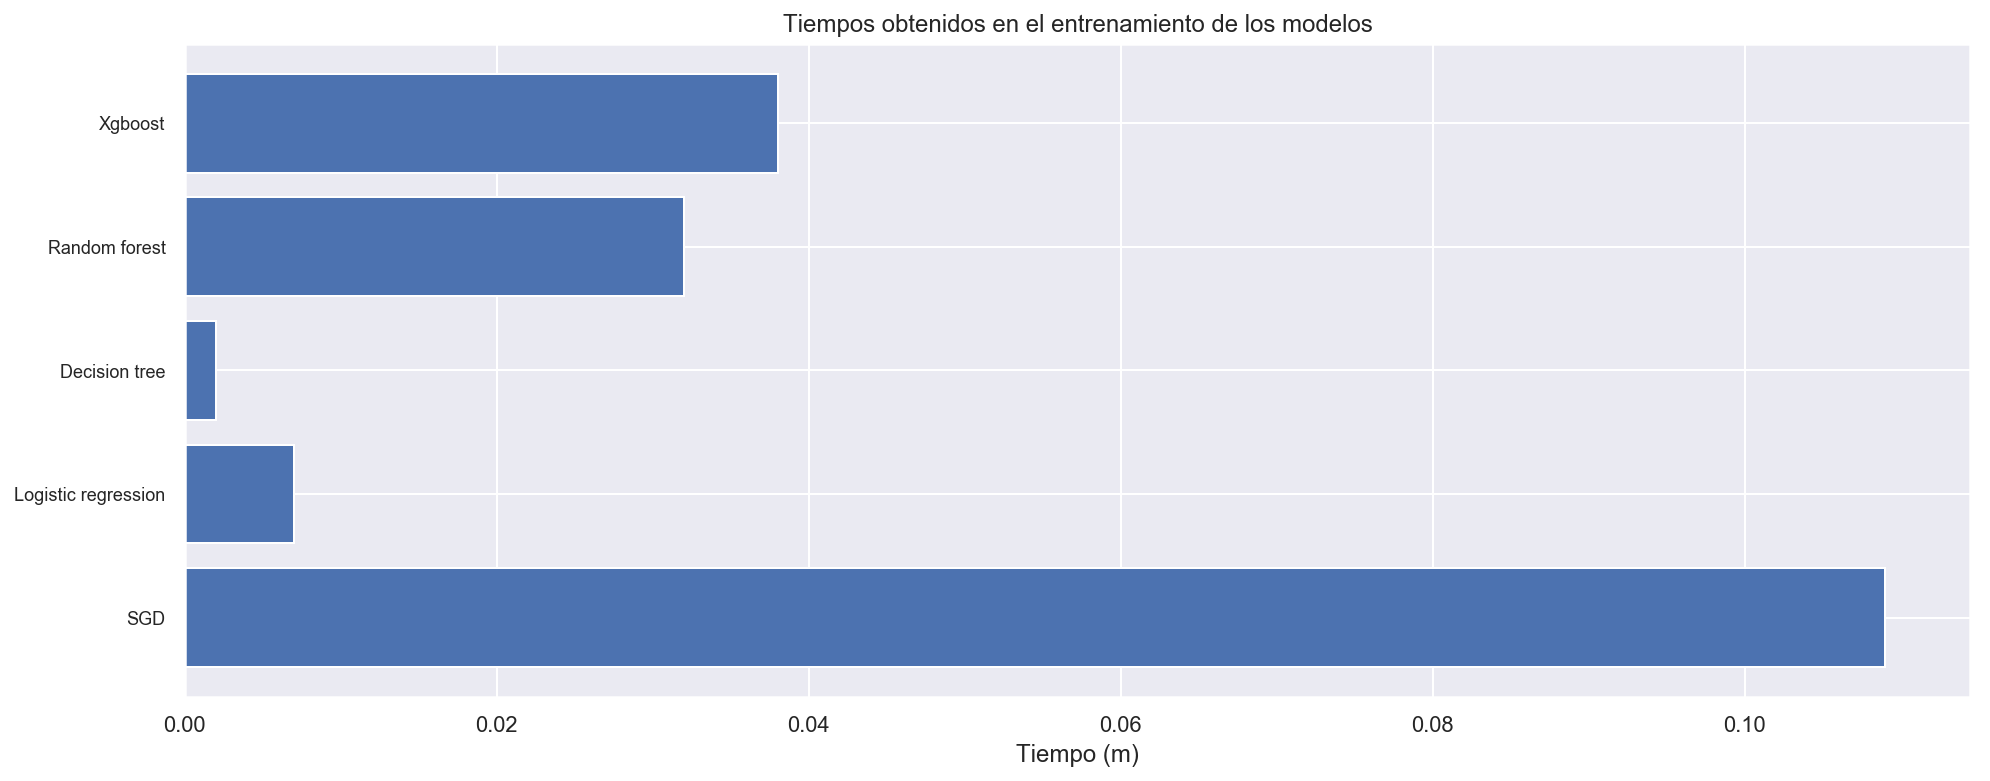

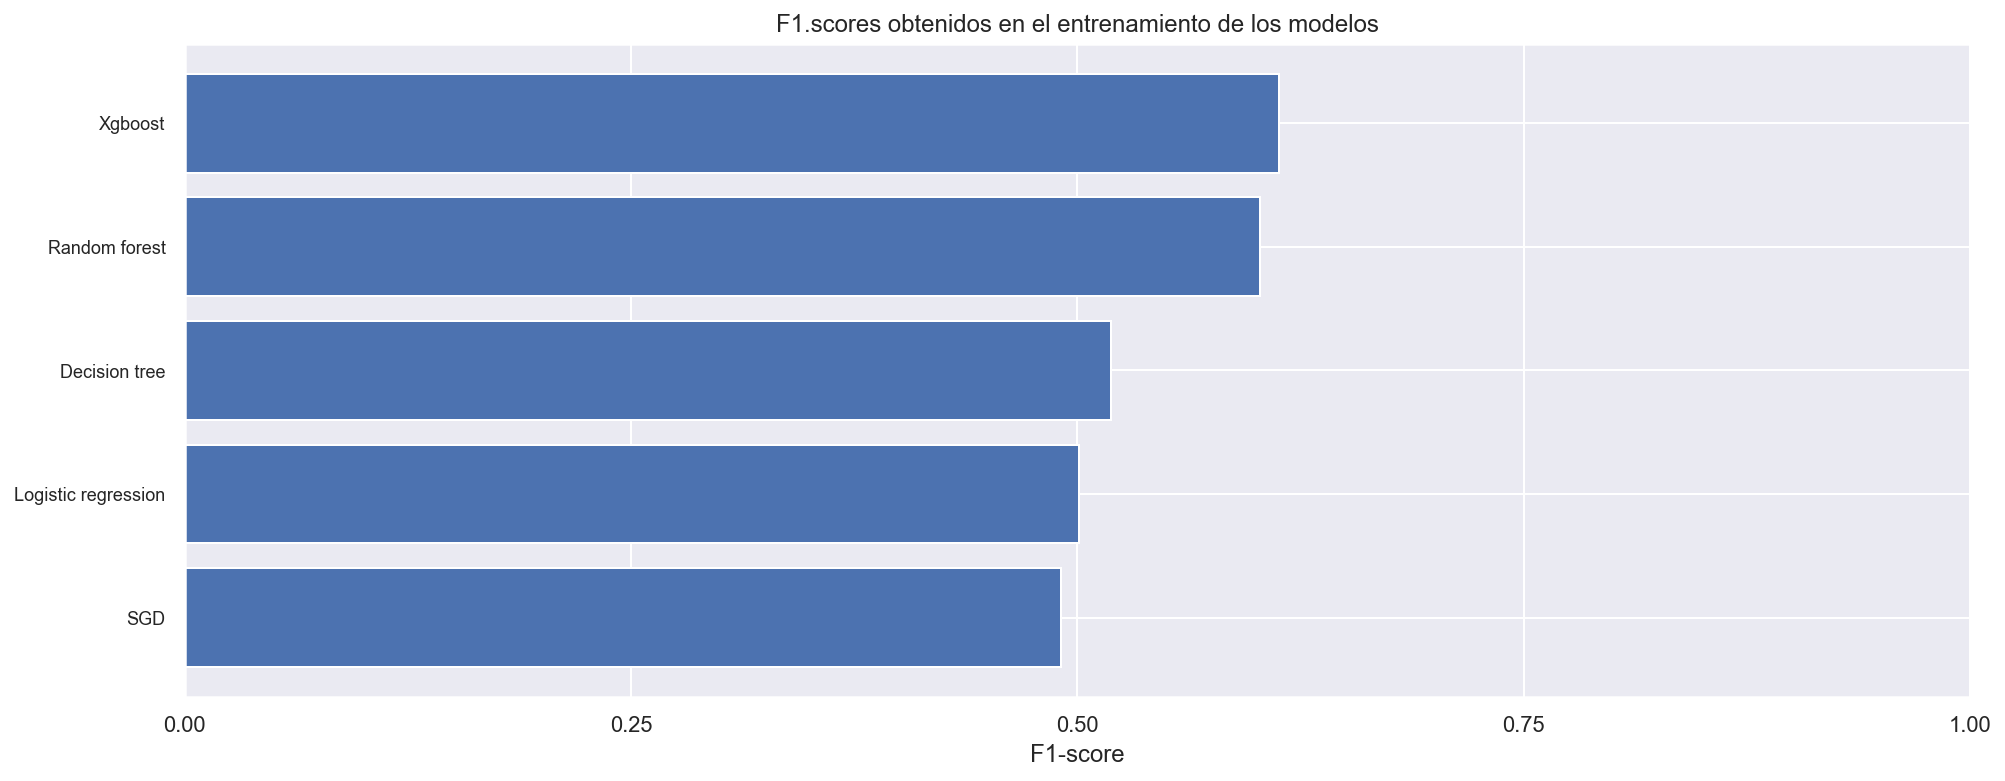

In [23]:
plt.figure(figsize=(16,6))
plt.title("Tiempos obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(times)), times, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xlabel('Tiempo (m)')
plt.show()

plt.figure(figsize=(16,6))
plt.title("F1.scores obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(accuracies)), accuracies, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xticks(np.linspace(0,1,5))
plt.xlabel('F1-score')
plt.show()

In [24]:
model = results['Xgboost']['estimator']

In [25]:
y_pred = model.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       235
           1       0.60      0.65      0.62        37

    accuracy                           0.89       272
   macro avg       0.77      0.79      0.78       272
weighted avg       0.90      0.89      0.90       272



In [27]:
X = df_modelar_new.drop(columns='quality').copy()
y = df_modelar_new['quality'].copy()

y_val_pred = model.predict(X)
print(classification_report(y, y_val_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       207
           1       0.47      0.64      0.54        33

    accuracy                           0.85       240
   macro avg       0.70      0.76      0.72       240
weighted avg       0.87      0.85      0.86       240



Accuracy final obtenido: **0.85**

Tras hacer una búsqueda de hiperparámetros con los modelos más adecuados para este tipo de problemas, hemos conseguido obtener un accuracy más que decente, pero lo más importante es que hemos conseguido obtener un modelo que discrimina de mejor manera los vinos que realmente son buenos y los que son malos. Cosa que no sucedia con el primer modelo base con el que hemos probado, esto ha sido gracias al oversampling que hemos realizado junto con la búsqueda exhaustiva de hiperparámetros en los modelos que hemos testeado.